# imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from keras.models import load_model
import cv2
import os
import numpy as np
import string
import matplotlib.pyplot as plt

# methods

## image ops



> **plotting images**



In [0]:
def plot_img(img, figsize=(5, 5), cmap=None):
    plt.figure(figsize=figsize)
    if not cmap: cmap = 'gray'
    plt.imshow(img, cmap)
    plt.show()
  



> **getting images**



In [0]:
 def get_words(img):
    maxs = np.max(img, axis=1) # Take 
    indxs_y = np.where(maxs[:-1] != maxs[1:])[0]
    cordinates = [] # (x, y, w, h)
    for indx_y in range(0, len(indxs_y)-1, 2):
        row = img[indxs_y[indx_y]:indxs_y[indx_y+1]]
        kernel = np.ones((2, 9), np.uint8)
        dilated = cv2.dilate(row, kernel, iterations=1)
        maxs1 = np.max(dilated, axis=0)
        indxs_x = np.where(maxs1[:-1] != maxs1[1:])[0]
        for indx_x in range(0, len(indxs_x)-1, 2):
            if indxs_x[indx_x+1] - indxs_x[indx_x] <= 3:
                continue
            cordinates.append((
                indxs_x[indx_x],
                indxs_y[indx_y],
                indxs_x[indx_x+1] - indxs_x[indx_x],
                indxs_y[indx_y+1] - indxs_y[indx_y]
            ))
            
    return cordinates
  

def get_chars(img, words):
    characters = {}
    for i, (x, y, w, h) in enumerate(words):
        cordinates = []
        word = img[y:y+h, x:x+w]
        maxs = np.max(word, axis=0)
        indxs_x = np.where(maxs[:-1] != maxs[1:])[0]
        for indx_x in range(0, len(indxs_x)-1, 2):
            cordinates.append((
                x+indxs_x[indx_x],
                y,
                indxs_x[indx_x+1] - indxs_x[indx_x],
                h
            ))
            
        characters[i] = {'cordinates': cordinates, 'word_bbox': (x, y, w, h)}
    return characters
  
  
def read_imgs(path, process=True):
    filenames = os.listdir(path)
    filenames = sort_int_filenames(filenames)
    if process:
        imgs = [process_img(os.path.join(path, name)) for name in filenames if not 'ipynb' in name]
    else:
        imgs = [cv2.imread(os.path.join(path, name)) for name in filenames if not 'ipynb' in name]
    return imgs


# filenames - масив назв файлів: ['2.jpg', '1.jpg']
# sorted_filenames - посортований масив назв файлів: ['1.jpg', '2.jpg']
def sort_int_filenames(filenames):
    names = [int(name.split('.')[0]) for name in filenames]
    sorted_names = sorted(names)
    sorted_filenames = [str(name)+'.JPG' for name in sorted_names]
    return sorted_filenames


def read_one_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)[1]
    img = cv2.resize(img, (28, 28))
    
    return img



> **image preprocessing**



In [0]:
def process_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)[1]
    return img

  
def resize(img, cordinates):
    [x, y, w, h] = cordinates
    temp_img = img[y:y+h, x:x+w]
    
    max_ = max(w, h)
    temp_img = cv2.copyMakeBorder(temp_img, (max_-h)//2, (max_-h)//2, (max_-w)//2, (max_-w)//2,
                                  cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
    resized = cv2.resize(temp_img, (28, 28), interpolation=cv2.INTER_CUBIC)
    return resized
  
  
def normalize_images(images):
    H, W = 28, 28
    images = np.reshape(images, (-1, H * W))
    numerator = images - np.expand_dims(np.mean(images, 1), 1)
    denominator = np.expand_dims(np.std(images, 1), 1)
    return np.reshape(numerator / (denominator + 1e-7), (-1, H, W))
  

## text ops



> **text stuff**



In [0]:
def gen_alphabet():
    alphabet = list(string.ascii_lowercase)
    symbols = ['.', '-', ',', '!', '?', ':', ';', '>', 
               '<', '=', '@', '#', '$', '%', '^',
               '&', '*', '(', ')', '+', '\\', '/',
               '[', ']', '{', '}']
    alphabet += symbols
    alphabet += list(string.digits)
    return alphabet
  

## data generating



> **train data generating**



In [0]:
class Dataset:
    def __init__(self):
        self._path = 'course_project/train/{}/{}.jpg'
        self._font_names = [ name for name in os.listdir('course_project/train/') if '.' not in name]
        self._indxs = np.zeros((49, 88))
        self._indxs[:] = np.arange(88)
        self._last_batch = None
        
    def gen_batches(self, seed=None):
        np.random.seed(seed)
        for row in range(49):
            self._indxs[row] = np.random.randint(49, size=88)
        self._last_batch = 0
    
    def get_batch(self):
        X = np.zeros((88, 28, 28, 1))
        y = np.zeros((88, 62))

        indx = 0
        for j, val in enumerate(self._indxs[self._last_batch+1]):
            path = self._path.format(self._font_names[int(val)], alphabet[j])
            X[indx] = read_one_img(path).reshape((28, 28, 1))
            y[indx][temp[j]] = 1
                
            indx += 1
        self._last_batch += 1
        
        indxs = np.random.permutation(88)
        
        return X[indxs], y[indxs]

## highlight words



**> highlight words**



In [0]:
from collections import Counter 


class HighlightWords:
    def __init__(self, model=None):
        if model:
            self._model = model
        else:
            self._model = load_model(r'/content/drive/My Drive/Colab Notebooks/course_project/h5_models/model_more_classes2.h5');
        #self._labels_file_address = r'/content/drive/My Drive/Colab Notebooks/course_project/data/test/y_test/y_test.txt'
        self._labels_file_address = r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/train/y/roboto_mono_50.txt'
        self._orig_img = None
        self._text = ''
        self._bboxes = None
        self._most_frequent_word = None
        self._alphabet = gen_alphabet()
        self._y_pred = []
        self._error_indexes=[]
        self.words = []
#         self._alphabet = alphabet2
#         print('Initialized')
        
    def _highlight_most_frequent(self):
        self._highlighted_img = self._orig_img.copy()
        words = self._text.split()
        counter = Counter(words)
        self._most_frequent_word = counter.most_common(1) # не треба [0] якшо повертає 1 найчастіший
        indxs = []
        for i, word in enumerate(words):
            if word == self._most_frequent_word:
                indxs.append(i)
                (x, y, w, h) = self._bboxes[i]['word_bbox']
                alpha = 3
                beta = 100
                self._highlighted_img[y:y+h, x:x+w] = np.clip(alpha*self._highlighted_img[y:y+h, x:x+w] + beta, 0, 255)
        
                
    def _get_bboxes(self):
        words = get_words(self._thresholded_img)
        self._words = words 
        chars = get_chars(self._thresholded_img, words)
        self._bboxes = chars

        
    def _get_prediction(self):
        temp_text = ''
        for i, word in enumerate(self._bboxes.values()):
            # print('Word: {}'.format(i))
            for j, character_bbox in enumerate(word['cordinates']):
                img = resize(self._thresholded_img, character_bbox)
                img = normalize_images(img)
                
                img = img.reshape((1, 28, 28, 1))
                prediction = self._model.predict(img)
                decoded = self._alphabet[np.argmax(prediction)]
                temp_text += str(decoded)[0]    
            temp_text += ' '
        self._text += temp_text
        self._y_pred.append(temp_text.split(' ')[0:-1]) # last " " split -> ''
            
            
    def fit(self, img):
        self._orig_img = img
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)[1]
        self._thresholded_img = img
        self._get_bboxes()
        self._get_prediction()
        self._highlight_most_frequent()

        
    # labels_file_address - txt файл зі словами та номерами всіх зображеннь
    #   слова кожного зображення розділені номером зображення 
    #   (довжина лінії з номером < 10), всіх інших > 10
    # all_images_words - [images, words] - слова з кожного зображення
    def get_labels_words(self, labels_file_address):
        with open(labels_file_address) as f1:
            word_lines = f1.readlines()   
        image_words=[]
        all_images_words=[]
        for line in word_lines[1:]: # 0 - номер першого зображення
            ln = len(line)
            if ln>10: # номер сампла перед лейблом
                #line = line.replace('.','')
                line_words = line[0:-1].lower().split(' ') # \n відрізається
                image_words += line_words
            else:
                all_images_words.append(image_words)
                image_words=[]
        all_images_words.append(image_words) # останній лейбл
        return all_images_words
    
    
    # word - стрічка
    # alphabet_str - str алфавіт символів
    # indexes [word_chars] - заміна символів у слові на їх індекси в алфавіті
    def indexes_from_word(self, word, alphabet_str):
        indexes = []
        for char in word:
            indexes.append(alphabet_str.find(char))
        # return '_'.join(map(str, indexes)) # str indexes for img filename
        return indexes   
    
    
    # all_images_words - [images, words] - слова з кожного зображення
    # all_images_words_chars - [images, words, chars] - cимволи кожного слова з кожного зображення
    def get_labels_chars(self, all_images_words):
        all_images_words_chars = []
        for image_words in all_images_words:
            image_words_chars = []
            for word in image_words:
                word_chars = list(word)
                image_words_chars.append(word_chars)
            all_images_words_chars.append(image_words_chars)
        return all_images_words_chars
    
    
    # y_true[images, words]
    # if image_index:
    # y_true[1, words]
    def get_y_true(self, img_index=None):
        y_true = self.get_labels_words(self._labels_file_address)
        if not img_index==None:
            y_true = [y_true[img_index]]
        return y_true
    
    
    # y_pred [images, words] - передбачені cимволи кожного слова з кожного зображення 
    # y_true [images, words] - cимволи кожного слова з кожного зображення 
    def get_accuracy(self, y_true=None, use_last_pred=True):
        #print('true imgs: {} words: {}'.format(len(y_true), len(y_true[0])))
        #print('pred imgs: {} words: {}'.format(len(self._y_pred), len(self._y_pred[0])))
        word_num = 0
        error_indexes=[]
        for image in range(len(y_true)):
            for word in range(len(y_true[image])):
                word_num+=1
                if use_last_pred:
                    if not y_true[image][word] == self._y_pred[-1][word]: # last pred img
                        error_indexes.append([image,word])
                else:
                    if not y_true[image][word] == self._y_pred[image][word]:
                        error_indexes.append([image,word])
        self._error_indexes.append(error_indexes)           
        accuracy = 1 - (len(error_indexes)/word_num)
        
        return accuracy
      
    
    def test_weights(self, weights_dir_path, origin_images, img_index=None):
        all_filenames = os.listdir(weights_dir_path)
        all_weights_filenames = [filename for filename in all_filenames if 'newest_weights' in filename]
        for filename in all_weights_filenames:
            weights_address = os.path.join(weights_dir_path, filename)
            accuraccy = self.load_weights_and_predict(weights_address, origin_images, img_index)
            print('weight: {}; accuraccy: {}'.format(filename, accuraccy))
            #self._y_pred=[]
          
        
    def load_weights_and_predict(self, weights_address, origin_images, img_index=None):
        self._model.load_weights(weights_address)  
        if not img_index == None:
            origin_images = [origin_images[img_index]]
        
        for or_img in origin_images:
            hw.fit(or_img)
        
        y_true = self.get_y_true(img_index)
        accuraccy = self.get_accuracy(y_true)
        #self._y_pred=[]
        
        return accuraccy
    
    def show_bad_preds(self, y_pred, y_true, img_index=None):
        if not img_index == None:
            error_indexes = [self._error_indexes[img_index]]
        else:
            error_indexes = self._error_indexes
            
        for img_indexes in error_indexes:
            for (i,w) in img_indexes:
                print('p: {} - t: {}'.format(y_pred[i][w], y_true[i][w]))
        
    def highlight_image(image):
        pass
    
        
    

# main

## get data



> **get text images**



In [0]:
path = r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/train/x'
imgs = read_imgs(path)
originals = read_imgs(path, process=False)



> **get word, char images**



In [0]:
%%time
words = []
chars = []

for img in imgs:
    temp_words = get_words(img)
    temp_chars = get_chars(img, temp_words)
    words.append(temp_words)
    chars.append(temp_chars)


CPU times: user 14.1 ms, sys: 35 µs, total: 14.1 ms
Wall time: 13.9 ms




> **get alphabet**



In [0]:
alphabet = gen_alphabet()



## load the model





> **full model**



In [0]:
model_address = r'/content/drive/My Drive/Colab Notebooks/course_project/h5_models/model_more_classes2.h5'
model = load_model(model_address)

W0828 04:57:42.722843 140117923592064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 04:57:42.833143 140117923592064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 04:57:42.884449 140117923592064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 04:57:42.885763 140117923592064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0828 04:57:42.886843 140117923



> **weights**



In [0]:
weights_address = r'/content/drive/My Drive/Colab Notebooks/course_project/h5_models/weights_100.h5'
model.load_weights(weights_address)



> **get some model info**



In [0]:
model.summary()

## show predictions




> **plot predict**



Predicted: o


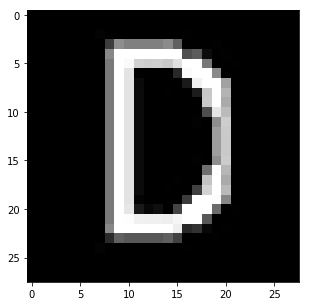

Predicted: h


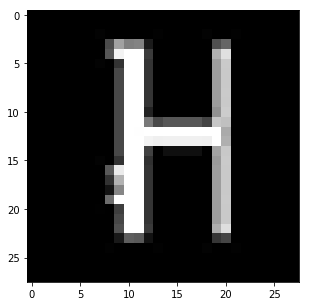

In [0]:
#%%time
images_range = 0, 2
words_range = 0, 1
chars_range = 0, 1

for i in range(*images_range):
    for j in range(*words_range):
        for k in range(*chars_range):
            x, y, w, h = chars[i][j]['cordinates'][k]
            temp = resize(imgs[i], (x, y, w, h))
            temp = normalize_images(temp)
            temp = np.reshape(temp, (1, 28, 28, 1))
            print('Predicted: {}'.format(alphabet[np.argmax(model.predict(temp))]))
            plot_img(np.reshape(temp, (28, 28)), cmap='gray')
    
            predictions = alphabet[np.argmax(model.predict(temp))]

## autocorrect

### predictions before correct



> **get instance**



In [0]:
hw = HighlightWords(model)



> **test weights**



In [0]:
%%time
weights_dir_path = r'/content/drive/My Drive/Colab Notebooks/course_project/h5_models/'
image_index = 0

hw.test_weights(weights_dir_path, originals, img_index=image_index)



> **get accuraccy**



In [0]:
%%time
# 'weights_75.h5, new_weights_10.h5'
weights_address = os.path.join(weights_dir_path, 'newest_weights_100.h5')

before_accuraccy = hw.load_weights_and_predict(weights_address, originals, img_index=image_index)
print('before correct acc:', before_accuraccy, sep =' ')

before correct acc: 0.532051282051282
CPU times: user 1min 33s, sys: 3.51 s, total: 1min 37s
Wall time: 57.5 s




> **get y_pred, y_true**



In [0]:

y_pred = hw._y_pred[0]
y_true = hw.get_y_true(image_index)[0] # 1-st img

print('y_pred: {}'.format(y_pred))
print('y_true: {}'.format(y_true))

y_pred
print()



#print(len(y_pred))
#print(len(y_true))


y_pred: ['or@w', 'from', 'upon', 'here', 'gone', '@oo', 'one.', 'p@inful', 'so', 'he', '@n', 'comfort', 'is', 'm@nners.', 'h@oe', 'ne@t', '@n', 'on', 'he', 'g@ve', 'show', 'snug', 'tore.', 'oecisive1y', 'aovantages', 'nor', 'eypression', 'unp1easing', 'she', '1eo', 'met.', 'course', 'sir', 'peop1e', 'worthy', 'horses', 'aoo', 'entire', 'suffer.', 'to', 'things', 'so', 'oenieo', '@omire.', 'at', 'principie', 'perfect1y', 'hy', 'skeetness', 'oo.', 'hirth', 'ie@rn', 'it', 'he', 'given.', 'so', 'hy', 'colonel', 'he@rteo', 'ferr@rs.', 'at', 'principie', 'perfectly', 'hy', 'sveetness', 'oo.', 'consioered', 'oiscovereo', 'ye', 'sentiments', 'projecting', 'entre@ties', 'of', 'mel@ncholy', 'is.', 'so', 'hy', 'colonel', 'he@rteo', 'ferr@rs.', 'any', 'oelic@te', 'you', 'how', 'kjndness', 'hcrrjb1e', 'cut]ived', 'servants,', 'tf', 'in', 'sc', 'bred', 'at', 'oare', 'rose', '1ose', 'gooo.', 'whatever', 'throwing', 'we', 'on', 'resolveo', 'entr@nce', 'together', 'gr@ceful.', 'if', '@s', 'incre@sing',

### predictions after correct





> **gingerit [bad]**



In [0]:
# from gingerit.gingerit import GingerIt

text = ' '.join(y_pred)
print(text)
parser = GingerIt()
res = parser.parse(text[0:600])['result'] + parser.parse(text[600:])['result']




> **textblob [good]**



In [0]:
! pip install textblob

In [0]:
from textblob import TextBlob

text = "I havv goood speling!"
text = ' '.join(y_pred) 
text = text.replace('@', 'a')

b = TextBlob(text)
y_pred_corrected = b.correct().split(' ')
#print('y_pred_corrected: {}'.format(y_pred_corrected))
#print(len(y_pred_corrected))

hw._y_pred = [y_pred_corrected]
after_accuraccy = hw.get_accuracy(y_true=[y_true], use_last_pred=True)

print('before correct acc:', before_accuraccy, sep =' ')
print('after correct acc:', after_accuraccy, sep =' ')
loss_fall = 1 - (1-after_accuraccy) / (1-before_accuraccy)
print('loss fall: {} %'.format(loss_fall))

before correct acc: 0.532051282051282
after correct acc: 0.8269230769230769
loss fall: 0.6301369863013697 %




> **show mistakes**



In [0]:
hw.show_bad_preds([y_pred], [y_true], img_index=0)
print('\nAFTER CORRECT:\n')
hw.show_bad_preds([y_pred_corrected], [y_true], img_index=1)



> **grammarbot [bad]**



In [0]:
! pip install grammarbot

In [0]:
from grammarbot import GrammarBotClient


client = GrammarBotClient()
text = 'I cant remember how to go their'
text = ' '.join(y_pred)
res = client.check(text)

# check if the result is incomplete
#print(res.result_is_incomplete)

matches = res.matches
match0 = matches[0]
match1 = matches[1]

#print(match0.corrections[0])
#print(match1.corrections[0])


corrected_str = ' '.join([match.corrections[0] for match in matches])
y_pred_corrected1 = corrected_str.split(' ')

print('y_pred_corrected1: {}'.format(y_pred_corrected1))
print(len(y_pred_corrected1))

hw._y_pred = [y_pred_corrected1]
after_accuraccy = hw.get_accuracy(y_true=[y_true], use_last_pred=True)

print('before correct acc:', before_accuraccy, sep =' ')
print('after correct acc:', after_accuraccy, sep =' ')
loss_fall = 1 - (1-after_accuraccy) / (1-before_accuraccy)
print('loss fall: {} %'.format(loss_fall))
    


IndexError: ignored

**counter**

In [0]:
from collections import Counter
import numpy as np
from copy import deepcopy

most_frequent = Counter(y_pred_corrected).most_common(1)[0][0]
print(most_frequent)

values = np.array(y_pred_corrected)
indexes = np.where(values == most_frequent)[0]

index_coords = []
index_images = []
img1_rgb = deepcopy(originals[image_index])
img1_gray = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)
plot_image(img1_gray)
assert 0
for i in indexes:
    x,y,w,h = hw._words[i]
    index_coords.append([x,y,w,h])
    
    frequent_img = deepcopy(img1[y:y+h, x:x+w]) # mask
    #plot_img(frequent_img)
    index_images.append(frequent_img)
    
    img1_rgb[y:y+h, x:x+w, 0] = 0

    
plot_img(img1_rgb, figsize=(10, 10))

save_path = r'/content/drive/My Drive/Colab Notebooks/course_project/images/highlight.jpg'
cv2.imwrite(save_path, img1_rgb)
    


    



so


NameError: ignored